In [1]:
import torch
import os
import logging
import argparse
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import misc
import config
from checkpoints import CheckpointIO
from metricrecord import Metric, Record

from transforms import apply_rot
from register_utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [46]:
cfg = misc.load_config('configs/test/reg_ideal.yaml')
is_cuda = (torch.cuda.is_available())
device = torch.device("cuda" if is_cuda else "cpu")
out_dir, gen_dir = config.cfg_f_out_test(cfg)
dataset = config.cfg_dataset(cfg, 'test')
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, num_workers=3, shuffle=True)

model = config.cfg_model(cfg, device)

checkpointio = CheckpointIO(model, checkpoint_dir=out_dir)
checkpointio.load(cfg['testing']['model_file'])
generator = config.cfg_generator(cfg, device, model)

03-05 12:06:45 Hey, logging is written to out/reg/test_ideal/msgs.log!
03-05 12:06:45 cfg is saved at out/reg/test_ideal/cfg.yaml
03-05 12:06:45 {'callback': {'autosave_every': 10000, 'checkpoint_every': 50000, 'print_every': 200, 'validate_every': 10000, 'visualize_every': 0}, 'checkpoint': {'model_selection_metric': 'angle', 'model_selection_mode': 'minimize'}, 'data': {'input': {'T_file': None, 'path': 'ModelNet40_install', 'pointcloud_file': 'pointcloud.npz'}, 'input_bench': {'T21_file': 'R21.npz', 'path': 'ModelNet40_benchmark', 'pointcloud_file_1': 'pcl_1.npy', 'pointcloud_file_2': 'pcl_2.npy'}, 'occ': {'points_file': 'points.npz', 'points_iou_file': 'points.npz', 'points_subsample': 1024, 'points_unpackbits': True, 'voxels_file': None}, 'test': {'centralize': False, 'reg_benchmark': False, 'reg': True, 'presamp_n': 1024, 'noise': 0.0, 'resamp': False, 'rotate': 180, 'subsamp': False}, 'train': {'centralize': False, 'n1': 1024, 'n2_max': 1200, 'n2_min': 400, 'noise': 0.01, 'presa

03-05 12:06:45 Total number of parameters: 10244167


out/reg/model_best.pt
=> Loading checkpoint from local file...


In [ ]:
!pip install ipympl
%matplotlib widget

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

points
points.occ
points_iou
points_iou.occ
inputs
inputs.normals
idx
inputs_2
points_2
T21
T21.deg


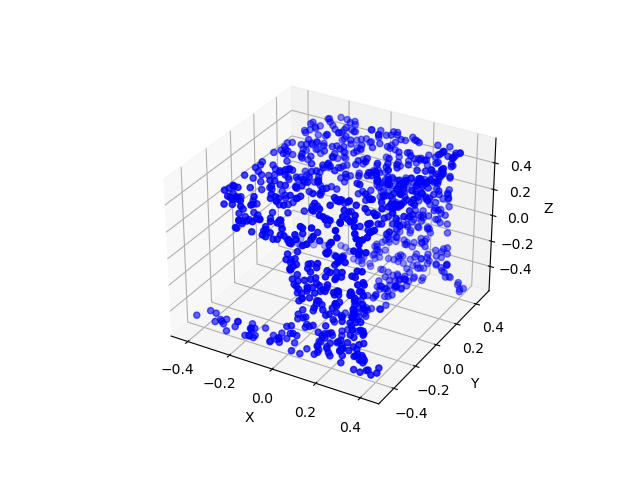

In [67]:
# evaluate
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# for it, data in enumerate(tqdm(test_loader)):
data = next(iter(test_loader))
sampled_points = data['inputs']
sampled_points_rotated = data['inputs_2']
# print(data['points'].shape)
for key, value in data.items():
    print(key)
    if isinstance(value, torch.Tensor):
        data[key] = value.to(device)
out_1, out_2_rot = generator.generate_latent_conditioned(data)
batch_size = out_1.shape[0]
out_1 = out_1.reshape(batch_size, -1, 3)
out_2_rot = out_2_rot.reshape(batch_size, -1, 3)

out_1 = out_1.to(torch.float64)
out_2_rot = out_2_rot.to(torch.float64)


out_1_cpu = out_1.to('cpu')
out_2_cpu = out_2_rot.to('cpu')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.scatter(sampled_points[0, :, 0], sampled_points[0, :, 1], sampled_points[0, :, 2], zdir='z', c= 'blue')
plt.show()


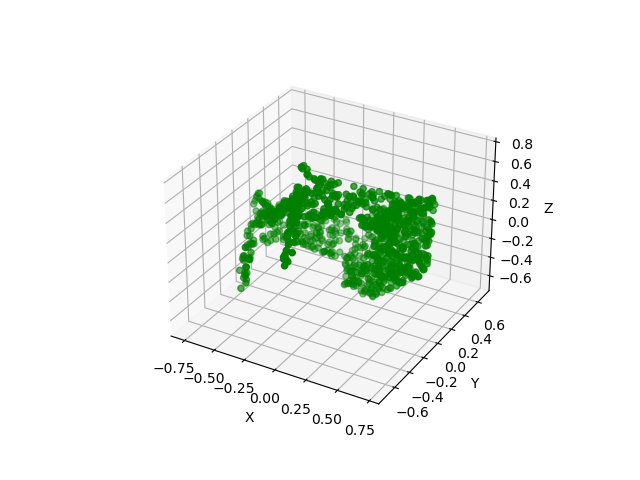

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sampled_points_rotated = data['inputs_2']
sampled_points_rotated = sampled_points_rotated.cpu()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.scatter(sampled_points_rotated[0, :, 0], sampled_points_rotated[0, :, 1], sampled_points_rotated[0, :, 2], zdir='z', c= 'green')


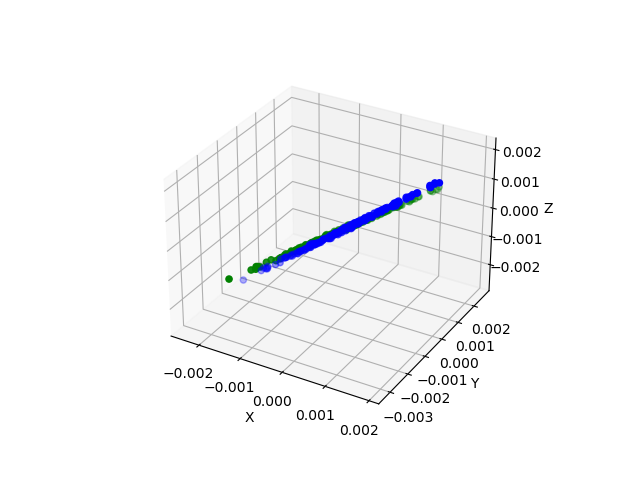

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.scatter(out_1_cpu[0, :, 0], out_1_cpu[0, :, 1], out_1_cpu[0, :, 2], zdir='z', c= 'blue')
ax.scatter(out_2_cpu[0, :, 0], out_2_cpu[0, :, 1], out_2_cpu[0, :, 2], zdir='z', c= 'green')

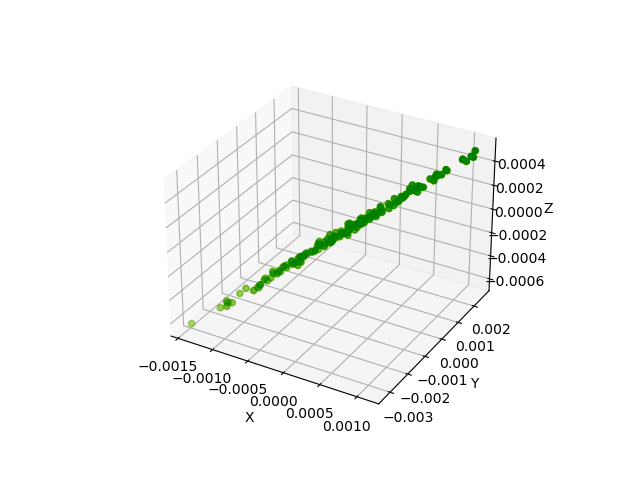

In [74]:
R_est = solve_R(out_1, out_2_rot)
R_gt = data['T21'].to(torch.float64)
out_1_rot_est = apply_rot(R_est, out_1)
out_1_rot = apply_rot(R_gt, out_1)

out_1_rot_cpu = out_1_rot.to('cpu')
out_1_rot_est_cpu = out_1_rot_est.to('cpu')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
# ax_2.scatter(out_1_rot_cpu[0, :, 0], out_1_rot_cpu[0, :, 1], out_1_rot_cpu[0, :, 2], zdir='z', c= 'blue')
ax.scatter(out_1_rot_est_cpu[0, :, 0], out_1_rot_est_cpu[0, :, 1], out_1_rot_est_cpu[0, :, 2], zdir='z', c= 'green')
ax.scatter(out_2_cpu[0, :, 0], out_2_cpu[0, :, 1], out_2_cpu[0, :, 2], zdir='z', c= 'yellow')

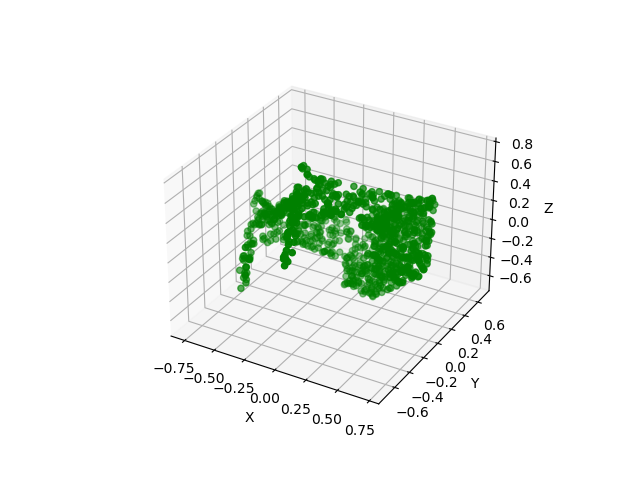

In [76]:
inputs_rot_est = apply_rot(R_est, data['inputs'])
inputs_rot_est = inputs_rot_est.cpu()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.scatter(inputs_rot_est[0, :, 0], inputs_rot_est[0, :, 1], inputs_rot_est[0, :, 2], zdir='z', c= 'green')
